In [1]:
from qiskit import Aer,QuantumRegister,ClassicalRegister
import qiskit as qs
import numpy as np
from  scipy.optimize import minimize_scalar,minimize
backend=qs.Aer.get_backend('qasm_simulator')

In [2]:
# Creating the initial Ansatz
def create_ansatz(qc,qr,th):
  qc.h(qr[0])
  qc.cx(qr[0],qr[1])
  qc.rx(th,qr[0])
  return qc
#Measurement in different basis
def measure(qc,qr,cr,op):
  if op=="XX":
    #change basis X=HZH
    qc.h(qr[0])
    qc.h(qr[1])
    qc.cx(qr[0],qr[1])
    qc.measure(qr[1],cr[0])
  elif op=="YY":
    #change basis Y=(HSdg)Z(HSdg)
    qc.sdg(qr[0])
    qc.sdg(qr[1])
    qc.h(qr[0])
    qc.h(qr[1])
    qc.cx(qr[0],qr[1])
    qc.measure(qr[1],cr[0])
  elif op=='ZZ':
    qc.cx(qr[0],qr[1])
    qc.measure(qr[1],cr[0])
  else :
    print("Measurement basis not supported")
  return qc


In [3]:
def hamiltonian(param):
  en=(1+param['ZZ']-param['XX']-param['YY'])/2
  return en

In [4]:
from qiskit.providers.basicaer.qasm_simulator import QuantumCircuit

def vqe(th,verbose=True):
  vqe_res=dict()
  qc_list=dict()
  shots=10000
  for op in ['XX','YY','ZZ']:
    qr=QuantumRegister(2,'qr')
    cr=ClassicalRegister(1,'cr')
    qc=QuantumCircuit(qr,cr)
    qc=create_ansatz(qc,qr,th)
    qc=measure(qc,qr,cr,op)

    counts=qs.execute(qc,backend,shots=shots).result().get_counts()

    if len(counts)==1:
      try:
        counts['0']
        mean=1
      except:
        mean=-1
    else:
      mean=(counts['0']-counts['1'])/shots

    vqe_res[op]=mean
    qc_list[op]=qc

  energy=hamiltonian(vqe_res)

  if verbose:
    print("mean value\n",vqe_res)
    print(f"{th:<10f}{energy:<10f}{vqe_res['XX']:<10f}{vqe_res['YY']:<10f}{vqe_res['ZZ']:<10f}")
    return energy,qc_list
  else:
    return energy

mean value
 {'XX': 1, 'YY': -0.9862, 'ZZ': 0.977}
0.200000  0.981600  1.000000  -0.986200 0.977000  


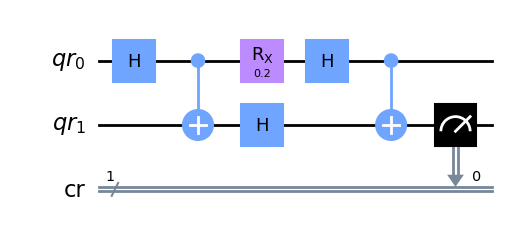

In [5]:
th=.2
energy,qc_list=vqe(.2)
qc_list['XX'].draw(output='mpl')

In [8]:
print(minimize_scalar(vqe, args=(False), bounds = (0, np.pi), method = "bounded"))
lowest,_=vqe(np.pi)
print(lowest)

     fun: -1.0
 message: 'Solution found.'
    nfev: 23
     nit: 23
  status: 0
 success: True
       x: 3.1204382682295955
mean value
 {'XX': 1, 'YY': 1, 'ZZ': -1}
3.141593  -1.000000 1.000000  1.000000  -1.000000 
-1.0


mean value
 {'XX': 1, 'YY': 1, 'ZZ': -1}
3.141593  -1.000000 1.000000  1.000000  -1.000000 
